In [ ]:
# Mounting my google drive in colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import joblib
from joblib import dump, load

<a id='1'></a>
# Data Load

<a id='2'></a>
# Data Preprocessing

In [ ]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Veri setini yükleyin
ds = load_dataset("winvoker/turkish-sentiment-analysis-dataset")

# 'train' ve 'test' veri setlerini pandas DataFrame'e dönüştürün
df_train = ds['train'].to_pandas()
df_test = ds['test'].to_pandas()

# Sadece 'text' ve 'label' kolonlarını seçin ve 'label' kolonunun adını 'labels' olarak değiştirin
df_train = df_train[['text', 'label']].rename(columns={'label': 'labels'})
df_test = df_test[['text', 'label']].rename(columns={'label': 'labels'})

# Eğitim ve test veri setlerini birleştirin
df_combined = pd.concat([df_train, df_test], ignore_index=True)

# Birleştirilen DataFrame'in ilk birkaç satırını gösterin
print("Combined DataFrame:")
print(df_combined.head())

# Kolon isimlerini almak için
columns_combined = df_combined.columns
print("\nCombined DataFrame Kolon isimleri:", columns_combined)

# Birleştirilen veri setini CSV dosyasına kaydedin
df_combined.to_csv('combined_sentiment_dataset.csv', index=False, encoding='utf-8')

# 'labels' sütununun dağılımını gösteren bir countplot oluşturun
sns.countplot(x='labels', data=df_combined)
plt.title("Combined DataFrame Etiket Dağılımı")
plt.show()


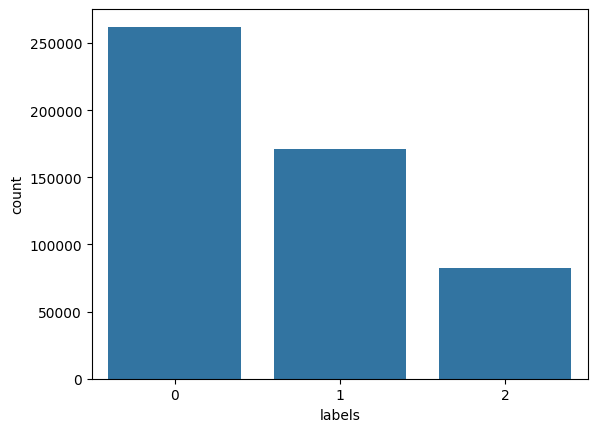

In [ ]:
df = pd.read_csv("/content/combined_sentiment_dataset.csv")
df
sns.countplot(x = df.labels);

In [ ]:
# Sınıfları ve her sınıfa ait veri sayısını görme
class_counts = df['labels'].value_counts()

# Sonuçları yazdırma
print(class_counts)

# Daha anlaşılır bir biçimde yazdırma
print("Sınıf sayısı:", len(class_counts))
print("Sınıflar ve veri sayıları:")
for label, count in class_counts.items():
    print(f"Sınıf {label}: {count} veri")


labels
0    262166
1    171178
2     82190
Name: count, dtype: int64
Sınıf sayısı: 3
Sınıflar ve veri sayıları:
Sınıf 0: 262166 veri
Sınıf 1: 171178 veri
Sınıf 2: 82190 veri


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Her sınıfın sayısını bulma
min_class_count = 82190

# Her sınıf için yeniden örnekleme ve birleştirme
balanced_df_list = []
for label in df['labels'].unique():
    class_subset = df[df['labels'] == label]
    class_resampled = resample(class_subset, replace=False, n_samples=min_class_count, random_state=42)
    balanced_df_list.append(class_resampled)

# Dengelenmiş veri setini birleştirme
balanced_df = pd.concat(balanced_df_list)

# Sonuçları kontrol etme
print(balanced_df['labels'].value_counts())

# Dengelenmiş veri setini kaydetme (isteğe bağlı)
balanced_df.to_csv('balanced_dataset.csv', index=False)


labels
0    82190
1    82190
2    82190
Name: count, dtype: int64


#TRAIN KISMI

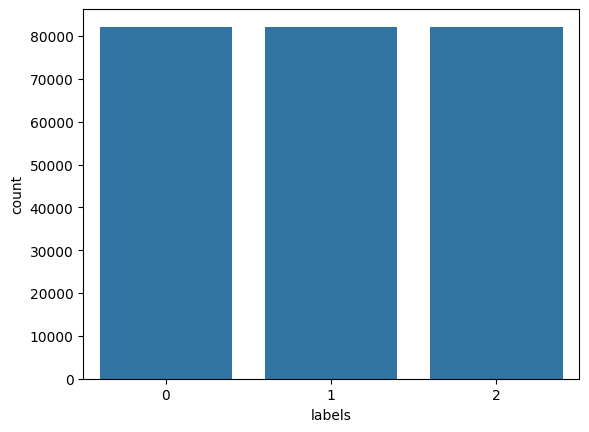

In [ ]:
df = pd.read_csv("/content/balanced_dataset.csv")
df
sns.countplot(x = df.labels);

In [ ]:
def clean_text(text):

    unwanted_pattern = r'[!.\n,:“”,?@#"]'
    regex = re.compile(unwanted_pattern)
    cleaned_text = regex.sub(" ", text)

    return cleaned_text

df['new_text'] = df['text'].astype(str).apply(clean_text)
df['new_text'] = df['new_text'].str.replace("[\d]", "")
df['new_text'] = df['new_text'].str.lower()
df

,text,labels,new_text
0,ebebeyn ünitesi kutunun içerisinde gelen şarjl...,0,ebebeyn ünitesi kutunun içerisinde gelen şarjl...
1,"Ürün geldi, bakalım çok hoş güzel görünüyor..",0,ürün geldi bakalım çok hoş güzel görünüyor
2,ürün elime uzun vadeli almış olmama rağmen kıs...,0,ürün elime uzun vadeli almış olmama rağmen kıs...
3,eksi ve artıları yazmak icin yeterli gibi gozu...,0,eksi ve artıları yazmak icin yeterli gibi gozu...
4,kaliteli ürün uygun fiyat tavsiye edilir,0,kaliteli ürün uygun fiyat tavsiye edilir
...,...,...,...
246565,zevkler ve rekler tartışılmaz. ona diyecek bi...,2,zevkler ve rekler tartışılmaz ona diyecek bi...
246566,Klasik korku filmi işte3-4 arkadaş tatile gid...,2,klasik korku filmi işte3-4 arkadaş tatile gid...
246567,sex bağımlısı bi kadın ve dinci bir adam bi f...,2,sex bağımlısı bi kadın ve dinci bir adam bi f...
246568,Ayırdığınız zamana yazık.İçerik olarak ve oyu...,2,ayırdığınız zamana yazık i̇çerik olarak ve oy...


In [ ]:
df.isna().sum()
df = df.dropna()
df.isna().sum()

,0
text,0
labels,0
new_text,0


#Dengeli veriyi eğitime gönderiyoruz

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
ineffective = stopwords.words('turkish')
ineffective[:5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['acaba', 'ama', 'aslında', 'az', 'bazı']

In [ ]:
df['new_text'] = df['new_text'].apply(lambda x: " ".join(x for x in x.split() if x not in ineffective))
df

,text,labels,new_text
0,ebebeyn ünitesi kutunun içerisinde gelen şarjl...,0,ebebeyn ünitesi kutunun içerisinde gelen şarjl...
1,"Ürün geldi, bakalım çok hoş güzel görünüyor..",0,ürün geldi bakalım hoş güzel görünüyor
2,ürün elime uzun vadeli almış olmama rağmen kıs...,0,ürün elime uzun vadeli almış olmama rağmen kıs...
3,eksi ve artıları yazmak icin yeterli gibi gozu...,0,eksi artıları yazmak icin yeterli gozukuyor
4,kaliteli ürün uygun fiyat tavsiye edilir,0,kaliteli ürün uygun fiyat tavsiye edilir
...,...,...,...
246565,zevkler ve rekler tartışılmaz. ona diyecek bi...,2,zevkler rekler tartışılmaz ona diyecek bir şey...
246566,Klasik korku filmi işte3-4 arkadaş tatile gid...,2,klasik korku filmi işte3-4 arkadaş tatile gide...
246567,sex bağımlısı bi kadın ve dinci bir adam bi f...,2,sex bağımlısı bi kadın dinci bir adam bi filmd...
246568,Ayırdığınız zamana yazık.İçerik olarak ve oyu...,2,ayırdığınız zamana yazık i̇çerik olarak oyuncu...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['new_text'], df['labels'], test_size=0.2, random_state=42)

tf_vector = TfidfVectorizer(max_features =  5000)
ct_vector = CountVectorizer(max_features = 5000)


X_train_vec = tf_vector.fit_transform(X_train)
X_test_vec = tf_vector.transform(X_test)

X_train_ct = ct_vector.fit_transform(X_train)
X_test_ct = ct_vector.transform(X_test)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Verileri bölme
X_train, X_test, y_train, y_test = train_test_split(df['new_text'], df['labels'], test_size=0.2, random_state=42)

# TF-IDF vektörizer
tf_vector = TfidfVectorizer(max_features=5000)
X_train_vec = tf_vector.fit_transform(X_train)
X_test_vec = tf_vector.transform(X_test)

# Count vektörizer
ct_vector = CountVectorizer(max_features=5000)
X_train_ct = ct_vector.fit_transform(X_train)
X_test_ct = ct_vector.transform(X_test)

# Naive Bayes modeli eğitme (TF-IDF ile)
nb_model_tfidf = MultinomialNB()
nb_model_tfidf.fit(X_train_vec, y_train)

# Naive Bayes modeli eğitme (CountVectorizer ile)
nb_model_ct = MultinomialNB()
nb_model_ct.fit(X_train_ct, y_train)

# Modelleri kaydetme
joblib.dump(tf_vector, 'tf_vector.pkl')
joblib.dump(ct_vector, 'ct_vector.pkl')
joblib.dump(nb_model_tfidf, 'nb_model_tfidf.pkl')
joblib.dump(nb_model_ct, 'nb_model_ct.pkl')

print("Modeller ve vektörizerler kaydedildi.")

# Modeli değerlendirme (TF-IDF ile)
y_pred_tfidf = nb_model_tfidf.predict(X_test_vec)
print("TF-IDF ile Naive Bayes Sınıflandırma Raporu:\n", classification_report(y_test, y_pred_tfidf))

# Modeli değerlendirme (CountVectorizer ile)
y_pred_ct = nb_model_ct.predict(X_test_ct)
print("CountVectorizer ile Naive Bayes Sınıflandırma Raporu:\n", classification_report(y_test, y_pred_ct))


Modeller ve vektörizerler kaydedildi.
TF-IDF ile Naive Bayes Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83     16288
           1       0.96      0.88      0.92     16409
           2       0.84      0.82      0.83     16617

    accuracy                           0.86     49314
   macro avg       0.86      0.86      0.86     49314
weighted avg       0.86      0.86      0.86     49314

CountVectorizer ile Naive Bayes Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83     16288
           1       0.97      0.88      0.92     16409
           2       0.85      0.79      0.82     16617

    accuracy                           0.85     49314
   macro avg       0.86      0.85      0.86     49314
weighted avg       0.86      0.85      0.86     49314



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import joblib

# Verileri bölme
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenizer'ı yarat ve train datasını tokenize et
num_words = 10000
maxlen = 200
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_df["new_text"])

# Tokenize edilmiş dataları tamamla (padding et)
X_train_dl = pad_sequences(tokenizer.texts_to_sequences(train_df["new_text"]), maxlen=maxlen)
X_test_dl = pad_sequences(tokenizer.texts_to_sequences(test_df["new_text"]), maxlen=maxlen)

y_train = train_df["labels"].values
y_test = test_df["labels"].values

# Tokenizer'ı kaydet
tokenizer_path = 'emb_tokenizer.pkl'
joblib.dump(tokenizer, tokenizer_path)
print("Tokenizer kaydedildi.")

# Model oluşturma
em_model = Sequential([
    Embedding(input_dim=num_words, output_dim=16, input_length=maxlen),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 sınıf için son katman
])

# Modeli derleme
em_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modeli eğitme
em_model.fit(X_train_dl, y_train, epochs=10, validation_data=(X_test_dl, y_test))

# Modeli kaydetme
em_model.save('EMBEDING.h5')


Tokenizer kaydedildi.
Epoch 1/10
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.8333 - loss: 0.4217 - val_accuracy: 0.9096 - val_loss: 0.2352
Epoch 2/10
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9190 - loss: 0.2125 - val_accuracy: 0.9148 - val_loss: 0.2227
Epoch 3/10
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9305 - loss: 0.1839 - val_accuracy: 0.9175 - val_loss: 0.2213
Epoch 4/10
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9383 - loss: 0.1658 - val_accuracy: 0.9186 - val_loss: 0.2231
Epoch 5/10
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.9444 - loss: 0.1518 - val_accuracy: 0.9189 - val_loss: 0.2264
Epoch 6/10
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9491 - loss: 0.1409 - val_accuracy: 0.9176 - val_loss: 0.2314
Epoch 7/10
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9529 - loss: 0.1319 - val_accuracy: 0.9179 - val_loss: 0.2364
Epoch 8/10
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accu

<a id='3'></a>
# Machine Learning Model

<a id='3.1'></a>
### Naive Bayes

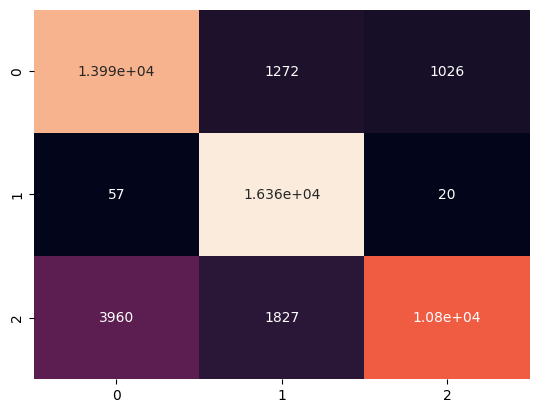

              precision    recall  f1-score   support

           0       0.78      0.86      0.82     16289
           1       0.84      1.00      0.91     16433
           2       0.91      0.65      0.76     16587

    accuracy                           0.83     49309
   macro avg       0.84      0.84      0.83     49309
weighted avg       0.84      0.83      0.83     49309



In [ ]:
nb_tf = BernoulliNB()
nb_tf.fit(X_train_vec, y_train)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cbar=False, fmt=".4g")
    plt.show()
    print(classification_report(y_test, y_pred))

result = pd.DataFrame(columns=['TF_Vectorizer_accuracy', 'Count_Vectorizer_accuracy',
                               'Model'])


evaluate_model(nb_tf, X_test_vec, y_test)


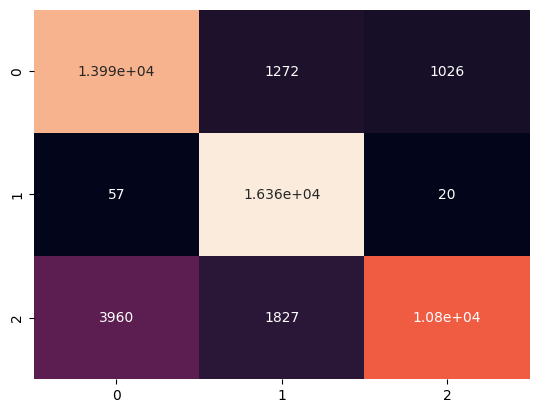

              precision    recall  f1-score   support

           0       0.78      0.86      0.82     16289
           1       0.84      1.00      0.91     16433
           2       0.91      0.65      0.76     16587

    accuracy                           0.83     49309
   macro avg       0.84      0.84      0.83     49309
weighted avg       0.84      0.83      0.83     49309



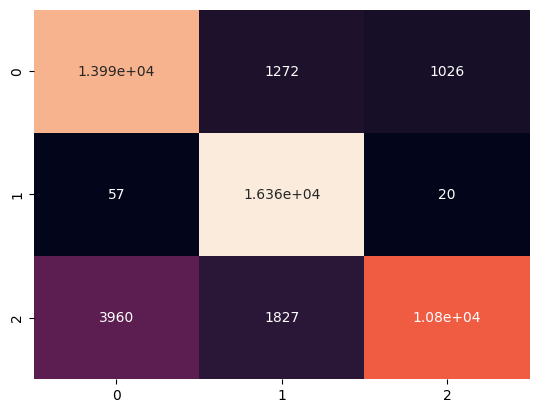

              precision    recall  f1-score   support

           0       0.78      0.86      0.82     16289
           1       0.84      1.00      0.91     16433
           2       0.91      0.65      0.76     16587

    accuracy                           0.83     49309
   macro avg       0.84      0.84      0.83     49309
weighted avg       0.84      0.83      0.83     49309

   TF_Vectorizer_accuracy  Count_Vectorizer_accuracy        Model
0                   0.834                      0.834  Naive Bayes


['/content/nb_tf.joblib']

In [ ]:
nb_ct = BernoulliNB()
nb_ct.fit(X_train_ct, y_train)
# Sonuçlar için boş DataFrame
result = pd.DataFrame(columns=['TF_Vectorizer_accuracy', 'Count_Vectorizer_accuracy', 'Model'])
# Yeni satır eklemek için pd.concat kullanın
new_row = {
    'Model': 'Naive Bayes',
    'Count_Vectorizer_accuracy': nb_ct.score(X_test_ct, y_test),
    'TF_Vectorizer_accuracy': nb_tf.score(X_test_vec, y_test)
}
result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)

# Model değerlendirmesi
evaluate_model(nb_ct, X_test_ct, y_test)
evaluate_model(nb_tf, X_test_vec, y_test)

# Sonuçların güncellenmiş hali
print(result)

dump(nb_ct, '/content/b_ct.joblib')
dump(nb_tf, '/content/nb_tf.joblib')


<a id='3.2'></a>
### Support Vector Machine

In [ ]:
svc_tf = SVC()
svc_tf.fit(X_train_vec, y_train)
evaluate_model(svc_tf, X_test_vec, y_test)

In [ ]:

svc_tf = SVC()
svc_tf.fit(X_train_vec, y_train)
evaluate_model(svc_tf, X_test_vec, y_test)
svc_ct = SVC()
svc_ct.fit(X_train_ct, y_train)
result = pd.DataFrame(columns=['TF_Vectorizer_accuracy', 'Count_Vectorizer_accuracy', 'Model'])

# Yeni satır eklemek için pd.concat kullanın
new_row = {
    'Model': 'Support Vector Machine',
    'Count_Vectorizer_accuracy':svc_ct .score(X_test_ct, y_test),
    'TF_Vectorizer_accuracy': svc_tf.score(X_test_vec, y_test)
}
result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)

# Model değerlendirmesi,
evaluate_model(svc_ct, X_test_ct, y_test)
evaluate_model(svc_tf, X_test_vec, y_test)
# Sonuçların güncellenmiş hali
print(result)

dump(svc_ct, '/content/drive/MyDrive/oflazer/elif/deep model')
dump(svc_tf, '/content/drive/MyDrive/oflazer/elif/deep model')

In [ ]:
# 'labels' kolonundaki değerleri değiştirin
df['labels'] = df['labels'].replace({
    'nötr': 1,
    'negatif': 0,
    'pozitif': 2
}).astype(int)

# Güncellenmiş DataFrame'i tekrar CSV dosyasına kaydedin
df.to_csv('output3.csv', index=False, encoding='utf-8')

# Değişiklikleri kontrol etmek için ilk birkaç satırı gösterin
df

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenizer'ı yarat və train datasını tokenize et
# Create Tokenizer and tokenize train data
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_df["new_text"])

# Tokenize edilmiş dataları tamamla (padding et)
# Padding tokenized data
maxlen = 200
X_train_dl = pad_sequences(tokenizer.texts_to_sequences(train_df["new_text"]), maxlen=maxlen)
X_test_dl = pad_sequences(tokenizer.texts_to_sequences(test_df["new_text"]), maxlen=maxlen)

y_train = train_df["labels"].values
y_test = test_df["labels"].values

tokenizer_path = 'emb_tokenizer.pkl'
joblib.dump(tokenizer, tokenizer_path)

print("Tokenizer kaydedildi.")

Tokenizer kaydedildi.


In [ ]:
import tensorflow as tf

# Rastgele tohumlama
tf.random.set_seed(42)

# Model oluşturma
em_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words, output_dim=16, input_length=maxlen),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 sınıf için son katman
])

# Modeli derleme
em_model.compile(loss='sparse_categorical_crossentropy',  # veya categorical_crossentropy
                 optimizer='adam',
                 metrics=['accuracy'])

# Modelin boyutlarını belirleyerek build etme
em_model.build(input_shape=(None, maxlen))

# Modelin özetini yazdırma
em_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 200, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 16)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,283 (630.01 KB)

 Trainable params: 161,283 (630.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss',
                                                   patience=2,
                                                   mode='min',
                                                   restore_best_weights=True)

In [ ]:
history_em = em_model.fit(X_train_dl, y_train, validation_data=(X_test_dl, y_test),
                            epochs= 20, batch_size=32, callbacks = [early_stopping])

Epoch 1/20
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.8306 - loss: 0.4423 - val_accuracy: 0.9073 - val_loss: 0.2448
Epoch 2/20
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.9152 - loss: 0.2234 - val_accuracy: 0.9148 - val_loss: 0.2264
Epoch 3/20
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - accuracy: 0.9282 - loss: 0.1895 - val_accuracy: 0.9179 - val_loss: 0.2225
Epoch 4/20
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - accuracy: 0.9363 - loss: 0.1706 - val_accuracy: 0.9190 - val_loss: 0.2220
Epoch 5/20
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.9427 - loss: 0.1567 - val_accuracy: 0.9186 - val_loss: 0.2238
Epoch 6/20
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.9470 - loss: 0.1457 - val_accuracy: 0.9192 - val_loss: 0.2279


1542/1542 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


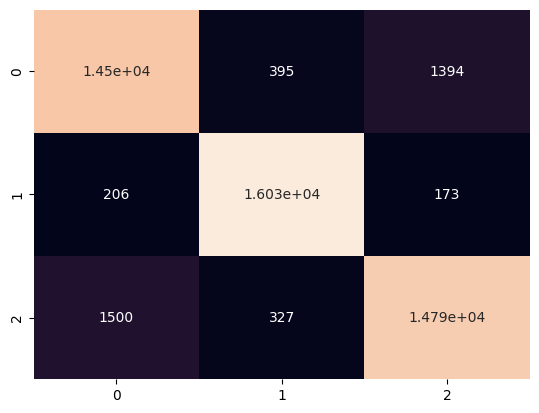

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     16288
           1       0.96      0.98      0.97     16409
           2       0.90      0.89      0.90     16617

    accuracy                           0.92     49314
   macro avg       0.92      0.92      0.92     49314
weighted avg       0.92      0.92      0.92     49314



In [ ]:
def evaluate_model_dl(model, X_test, y_test):
    # Modelin tahminlerini al
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Sınıf etiketlerini al

    # y_test'i de aynı şekilde sınıf etiketlerine dönüştür
    if y_test.ndim > 1:
        y_test_classes = np.argmax(y_test, axis=1)
    else:
        y_test_classes = y_test

    # Confusion matrix ve classification report hesapla ve göster
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, cbar=False, fmt=".4g")
    plt.show()
    print(classification_report(y_test_classes, y_pred_classes))

# Örnek bir DataFrame oluşturma
result_dl = pd.DataFrame(columns=['Accuracy', 'Model'])

# Modeli değerlendir
evaluate_model_dl(em_model, X_test_dl, y_test)

In [ ]:
# Başlangıçta boş bir DataFrame var
result_dl = pd.DataFrame(columns=['Model', 'Accuracy'])

# Yeni bir satır eklemek için dictionary ile DataFrame oluşturun
new_row = {
    'Model': 'EMBEDİNG',
    'Accuracy': em_model.evaluate(X_test_dl, y_test)[1]}

result_dl = pd.concat([result_dl, pd.DataFrame([new_row])], ignore_index=True)

# Sonuçları inceleyin
print(result_dl)
em_model.save('/content/drive/MyDrive/oflazer/elif/deep model/EMBEDING.h5')

1542/1542 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9196 - loss: 0.2195


      Model  Accuracy
0  EMBEDİNG     0.919


In [ ]:
# Rastgele tohumlama
tf.random.set_seed(42)

# Model oluşturma
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words, output_dim=16, input_length=maxlen),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 sınıf için son katman
])

# Modeli derleme
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modelin boyutlarını belirleyerek build etme
cnn_model.build(input_shape=(None, maxlen))

# Modelin özetini yazdırma
cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 200, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 196, 128)            │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_5               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,819 (698.51 KB)

 Trainable params: 178,819 (698.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn = cnn_model.fit(X_train_dl, y_train, validation_data=(X_test_dl, y_test),
                            epochs= 20, batch_size=32, callbacks = [early_stopping])

Epoch 1/20
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 151s 24ms/step - accuracy: 0.8624 - loss: 0.3396 - val_accuracy: 0.9193 - val_loss: 0.2132
Epoch 2/20
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 140s 23ms/step - accuracy: 0.9312 - loss: 0.1842 - val_accuracy: 0.9204 - val_loss: 0.2149
Epoch 3/20
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 140s 22ms/step - accuracy: 0.9505 - loss: 0.1408 - val_accuracy: 0.9195 - val_loss: 0.2422


1542/1542 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


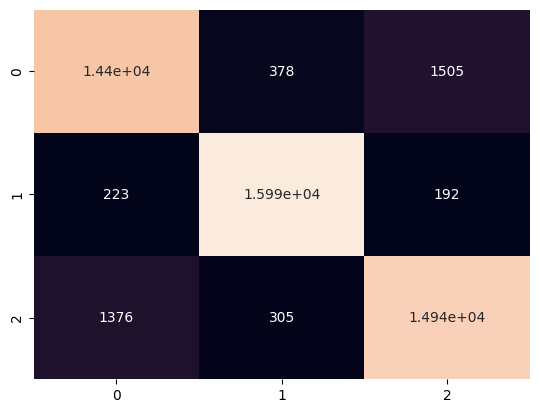

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     16288
           1       0.96      0.97      0.97     16409
           2       0.90      0.90      0.90     16617

    accuracy                           0.92     49314
   macro avg       0.92      0.92      0.92     49314
weighted avg       0.92      0.92      0.92     49314

1542/1542 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9184 - loss: 0.2117


  Model  Accuracy
0   CNN     0.919


In [ ]:

evaluate_model_dl(cnn_model, X_test_dl, y_test)

# Başlangıçta boş bir DataFrame var
result_dl = pd.DataFrame(columns=['Model', 'Accuracy'])

# Yeni bir satır eklemek için dictionary ile DataFrame oluşturun
new_row = {
    'Model': 'CNN',
    'Accuracy': cnn_model.evaluate(X_test_dl, y_test)[1]}

result_dl = pd.concat([result_dl, pd.DataFrame([new_row])], ignore_index=True)

# Sonuçları inceleyin
print(result_dl)
cnn_model.save('/content/drive/MyDrive/oflazer/elif/deep model/CNN_DL.h5')

In [ ]:

# Rastgele tohumlama
tf.random.set_seed(42)

# LSTM modelini oluşturma
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words, output_dim=16, input_length=maxlen),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 sınıf için son katman
])

# Modeli derleme
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modelin boyutlarını belirleyerek build etme
lstm_model.build(input_shape=(None, maxlen))

# Modelin özetini yazdırma
lstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 200, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,579 (658.51 KB)

 Trainable params: 168,579 (658.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = lstm_model.fit(X_train_dl, y_train, validation_data=(X_test_dl, y_test),
                            epochs= 20, batch_size=32, callbacks = [early_stopping])

Epoch 1/20
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 576s 92ms/step - accuracy: 0.8553 - loss: 0.3478 - val_accuracy: 0.9172 - val_loss: 0.2159
Epoch 2/20
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 631s 94ms/step - accuracy: 0.9270 - loss: 0.1934 - val_accuracy: 0.9192 - val_loss: 0.2138


1542/1542 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step


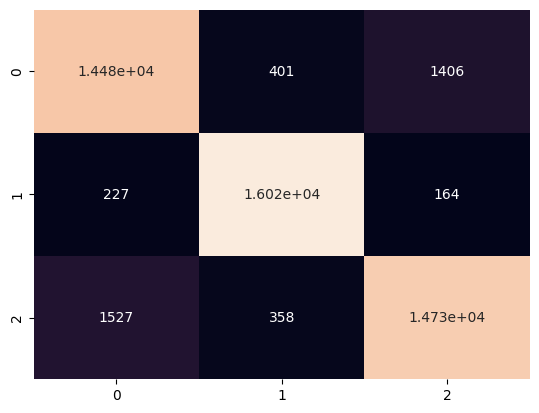

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     16288
           1       0.95      0.98      0.97     16409
           2       0.90      0.89      0.90     16617

    accuracy                           0.92     49314
   macro avg       0.92      0.92      0.92     49314
weighted avg       0.92      0.92      0.92     49314

1542/1542 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.9175 - loss: 0.2153


  Model  Accuracy
0  LSTM     0.917


In [ ]:
evaluate_model_dl(lstm_model, X_test_dl, y_test)

# Başlangıçta boş bir DataFrame var
result_dl = pd.DataFrame(columns=['Model', 'Accuracy'])

# Yeni bir satır eklemek için dictionary ile DataFrame oluşturun
new_row = {
    'Model': 'LSTM',
    'Accuracy': lstm_model.evaluate(X_test_dl, y_test)[1]}

result_dl = pd.concat([result_dl, pd.DataFrame([new_row])], ignore_index=True)

# Sonuçları inceleyin
print(result_dl)
lstm_model.save('/content/drive/MyDrive/oflazer/elif/deep model/LSTM_DL.h5')

In [ ]:
from flask import Flask, request, jsonify
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer, AutoModelForSequenceClassification
import torch
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

app = Flask(__name__)
app.config["DEBUG"] = True  # Hata ayıklama modunu etkinleştirin

# NER modeli ve tokenizer'ı yükleme
ner_model = AutoModelForTokenClassification.from_pretrained("savasy/bert-base-turkish-ner-cased")
ner_tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-ner-cased")
ner = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer, aggregation_strategy="first")

# Türkçe sentiment analiz modeli ve tokenizer'ı yükleme (Transformer modelleri)
sentiment_model = AutoModelForSequenceClassification.from_pretrained("emre/turkish-sentiment-analysis")
sentiment_tokenizer = AutoTokenizer.from_pretrained("emre/turkish-sentiment-analysis")

sent2_model = AutoModelForSequenceClassification.from_pretrained("anilguven/distilbert_tr_turkish_hotel_reviews")
sent2_tokenizer = AutoTokenizer.from_pretrained("anilguven/distilbert_tr_turkish_hotel_reviews")

# TF-IDF ve CountVectorizer modellerini yükleme
tf_vector = joblib.load('/content/tf_vector.pkl')
ct_vector = joblib.load('/content/ct_vector.pkl')
nb_model_tfidf = joblib.load('/content/nb_model_tfidf.pkl')
nb_model_ct = joblib.load('/content/nb_model_ct.pkl')

# Stopwords dosyasını yükleme
with open('/content/stop-words-mert.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())

Some weights of the model checkpoint at savasy/bert-base-turkish-ner-cased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
from flask import Flask, request, jsonify
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer, AutoModelForSequenceClassification
import torch
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

app = Flask(__name__)
app.config["DEBUG"] = True  # Hata ayıklama modunu etkinleştirin

# NER modeli ve tokenizer'ı yükleme
ner_model = AutoModelForTokenClassification.from_pretrained("savasy/bert-base-turkish-ner-cased")
ner_tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-ner-cased")
ner = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer, aggregation_strategy="first")

# Türkçe sentiment analiz modeli ve tokenizer'ı yükleme (Transformer modelleri)
sentiment_model = AutoModelForSequenceClassification.from_pretrained("emre/turkish-sentiment-analysis")
sentiment_tokenizer = AutoTokenizer.from_pretrained("emre/turkish-sentiment-analysis")

sent2_model = AutoModelForSequenceClassification.from_pretrained("anilguven/distilbert_tr_turkish_hotel_reviews")
sent2_tokenizer = AutoTokenizer.from_pretrained("anilguven/distilbert_tr_turkish_hotel_reviews")

# TF-IDF ve CountVectorizer modellerini yükleme
tf_vector = joblib.load('tf_vector.pkl')
ct_vector = joblib.load('ct_vector.pkl')
nb_model_tfidf = joblib.load('nb_model_tfidf.pkl')
nb_model_ct = joblib.load('nb_model_ct.pkl')

# Stopwords dosyasını yükleme
with open('/content/stop-words-mert.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())

# Sentiment analizi için fonksiyon
def analyze_sentiment(text):
    # Transformer modelleri
    inputs1 = sentiment_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs1 = sentiment_model(**inputs1)

    inputs2 = sent2_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs2 = sent2_model(**inputs2)

    logits1 = outputs1.logits
    probabilities1 = torch.softmax(logits1, dim=1)
    predicted_class1 = torch.argmax(probabilities1, dim=1).item()
    prob1 = probabilities1[0][predicted_class1].item()

    logits2 = outputs2.logits
    probabilities2 = torch.softmax(logits2, dim=1)
    predicted_class2 = torch.argmax(probabilities2, dim=1).item()
    prob2 = probabilities2[0][predicted_class2].item()

    # TF-IDF ve CountVectorizer için giriş verilerini hazırla
    tf_vec_text = tf_vector.transform([text])
    ct_vec_text = ct_vector.transform([text])

    predicted_class4 = nb_model_tfidf.predict(tf_vec_text)[0]
    predicted_class5 = nb_model_ct.predict(ct_vec_text)[0]

    prob4 = nb_model_tfidf.predict_proba(tf_vec_text)[0][predicted_class4]
    prob5 = nb_model_ct.predict_proba(ct_vec_text)[0][predicted_class5]

    sentiment_map = {0: "olumlu", 1: "nötr", 2: "olumsuz"}

    return {
        "model_1": {
            "class": sentiment_map[predicted_class1],
            "probability": prob1
        },
        "model_2": {
            "class": sentiment_map[predicted_class2],
            "probability": prob2
        },
        "model_4": {
            "class": sentiment_map[predicted_class4],
            "probability": prob4  # Naive Bayes modelinde doğrudan olasılık hesaplandı
        },
        "model_5": {
            "class": sentiment_map[predicted_class5],
            "probability": prob5  # Naive Bayes modelinde doğrudan olasılık hesaplandı
        }
    }

@app.route('/predict', methods=['POST'])
def analyze():
    try:
        data = request.json
        text = data.get("text")

        # NER analizi
        entities = ner(text)

        # Stopwords filtresi
        filtered_entities = [entity for entity in entities if entity['word'].lower() not in stopwords]

        # Entity'ler için sentiment analizi sonuçlarını saklamak için liste
        results = []
        entity_list = []

        # Her entity için sentiment analizi yap ve sonuçları sakla
        for entity in filtered_entities:
            entity_text = entity['word']
            sentiment_results = analyze_sentiment(entity_text)

            best_model = max(sentiment_results, key=lambda x: sentiment_results[x]["probability"] if sentiment_results[x]["probability"] != "N/A" else 0)
            best_sentiment = sentiment_results[best_model]["class"]

            results.append({
                "entity": entity_text,
                "sentiment": best_sentiment
            })
            entity_list.append(entity_text)
            print(entity_list)

        response = {
            "entity_list": entity_list,
            "results": results
        }
        print(response)
        return jsonify(response)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=6161)



Some weights of the model checkpoint at savasy/bert-base-turkish-ner-cased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:6161
 * Running on http://172.28.0.12:6161
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
!pip install pyngrok


In [ ]:
!ngrok authtoken F2F4OKZRDHMN6WB7S7KCP4MNXJP4J3PX





Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
ngrok_token = "2kPGgDlFg0dZsLgbY6LK77Z8XUT_7ipDprExUvNPzggDmnrbp"
!ngrok authtoken $ngrok_token

ng = ngrok.connect(6161)
print(ng.public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
https://5f2a-34-87-76-144.ngrok-free.app


In [ ]:
from flask import Flask, request, jsonify
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer, AutoModelForSequenceClassification
import torch
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

app = Flask(__name__)
app.config["DEBUG"] = True  # Hata ayıklama modunu etkinleştirin

# NER modeli ve tokenizer'ı yükleme
ner_model = AutoModelForTokenClassification.from_pretrained("savasy/bert-base-turkish-ner-cased")
ner_tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-ner-cased")
ner = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer, aggregation_strategy="first")

# Türkçe sentiment analiz modeli ve tokenizer'ı yükleme (Transformer modelleri)
sentiment_model = AutoModelForSequenceClassification.from_pretrained("emre/turkish-sentiment-analysis")
sentiment_tokenizer = AutoTokenizer.from_pretrained("emre/turkish-sentiment-analysis")

sent2_model = AutoModelForSequenceClassification.from_pretrained("anilguven/distilbert_tr_turkish_hotel_reviews")
sent2_tokenizer = AutoTokenizer.from_pretrained("anilguven/distilbert_tr_turkish_hotel_reviews")

# TF-IDF ve CountVectorizer modellerini yükleme
tf_vector = joblib.load('tf_vector.pkl')
ct_vector = joblib.load('ct_vector.pkl')
nb_model_tfidf = joblib.load('nb_model_tfidf.pkl')
nb_model_ct = joblib.load('nb_model_ct.pkl')

# Stopwords dosyasını yükleme
with open('/content/stop-words-mert.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())

# Sentiment analizi için fonksiyon
def analyze_sentiment(text):
    # Transformer modelleri
    inputs1 = sentiment_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs1 = sentiment_model(**inputs1)

    inputs2 = sent2_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs2 = sent2_model(**inputs2)

    logits1 = outputs1.logits
    probabilities1 = torch.softmax(logits1, dim=1)
    predicted_class1 = torch.argmax(probabilities1, dim=1).item()
    prob1 = probabilities1[0][predicted_class1].item()

    logits2 = outputs2.logits
    probabilities2 = torch.softmax(logits2, dim=1)
    predicted_class2 = torch.argmax(probabilities2, dim=1).item()
    prob2 = probabilities2[0][predicted_class2].item()

    # TF-IDF ve CountVectorizer için giriş verilerini hazırla
    tf_vec_text = tf_vector.transform([text])
    ct_vec_text = ct_vector.transform([text])

    predicted_class4 = nb_model_tfidf.predict(tf_vec_text)[0]
    predicted_class5 = nb_model_ct.predict(ct_vec_text)[0]

    prob4 = nb_model_tfidf.predict_proba(tf_vec_text)[0][predicted_class4]
    prob5 = nb_model_ct.predict_proba(ct_vec_text)[0][predicted_class5]

    sentiment_map = {0: "olumlu", 1: "nötr", 2: "olumsuz"}

    return {
        "model_1": {
            "class": sentiment_map[predicted_class1],
            "probability": prob1
        },
        "model_2": {
            "class": sentiment_map[predicted_class2],
            "probability": prob2
        },
        "model_4": {
            "class": sentiment_map[predicted_class4],
            "probability": prob4  # Naive Bayes modelinde doğrudan olasılık hesaplandı
        },
        "model_5": {
            "class": sentiment_map[predicted_class5],
            "probability": prob5  # Naive Bayes modelinde doğrudan olasılık hesaplandı
        }
    }

@app.route('/predict', methods=['POST'])
def analyze():
    try:
        data = request.json
        text = data.get("text")

        # NER analizi
        entities = ner(text)

        # Stopwords filtresi
        filtered_entities = [entity for entity in entities if entity['word'].lower() not in stopwords]

        # Entity'ler için sentiment analizi sonuçlarını saklamak için liste
        results = []
        entity_list = []

        # Her entity için sentiment analizi yap ve sonuçları sakla
        for entity in filtered_entities:
            entity_text = entity['word']
            sentiment_results = analyze_sentiment(entity_text)

            best_model = max(sentiment_results, key=lambda x: sentiment_results[x]["probability"] if sentiment_results[x]["probability"] != "N/A" else 0)
            best_sentiment = sentiment_results[best_model]["class"]

            results.append({
                "entity": entity_text,
                "sentiment": best_sentiment
            })
            entity_list.append(entity_text)
            print(entity_list)

        response = {
            "entity_list": entity_list,
            "results": results
        }
        print(response)
        return jsonify(response)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=6161)



In [ ]:

      !pip install uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00


In [ ]:
# prompt: fastapi install

!pip install fastapi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.0 MB/s eta 0:00:00


In [ ]:
from flask import Flask, request, jsonify
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer, AutoModelForSequenceClassification
import torch
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

app = Flask(__name__)
app.config["DEBUG"] = True  # Hata ayıklama modunu etkinleştirin

# NER modeli ve tokenizer'ı yükleme
ner_model = AutoModelForTokenClassification.from_pretrained("savasy/bert-base-turkish-ner-cased")
ner_tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-ner-cased")
ner = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer, aggregation_strategy="first")

# Türkçe sentiment analiz modeli ve tokenizer'ı yükleme (Transformer modelleri)
sentiment_model = AutoModelForSequenceClassification.from_pretrained("emre/turkish-sentiment-analysis")
sentiment_tokenizer = AutoTokenizer.from_pretrained("emre/turkish-sentiment-analysis")

sent2_model = AutoModelForSequenceClassification.from_pretrained("anilguven/distilbert_tr_turkish_hotel_reviews")
sent2_tokenizer = AutoTokenizer.from_pretrained("anilguven/distilbert_tr_turkish_hotel_reviews")

# TF-IDF ve CountVectorizer modellerini yükleme
tf_vector = joblib.load('tf_vector.pkl')
ct_vector = joblib.load('ct_vector.pkl')
nb_model_tfidf = joblib.load('nb_model_tfidf.pkl')
nb_model_ct = joblib.load('nb_model_ct.pkl')

# Stopwords dosyasını yükleme
with open('/content/stop-words-mert.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())

# Sentiment analizi için fonksiyon
def analyze_sentiment(text):
    # Transformer modelleri
    inputs1 = sentiment_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs1 = sentiment_model(**inputs1)

    inputs2 = sent2_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs2 = sent2_model(**inputs2)

    logits1 = outputs1.logits
    probabilities1 = torch.softmax(logits1, dim=1)
    predicted_class1 = torch.argmax(probabilities1, dim=1).item()
    prob1 = probabilities1[0][predicted_class1].item()

    logits2 = outputs2.logits
    probabilities2 = torch.softmax(logits2, dim=1)
    predicted_class2 = torch.argmax(probabilities2, dim=1).item()
    prob2 = probabilities2[0][predicted_class2].item()

    # TF-IDF ve CountVectorizer için giriş verilerini hazırla
    tf_vec_text = tf_vector.transform([text])
    ct_vec_text = ct_vector.transform([text])

    predicted_class4 = nb_model_tfidf.predict(tf_vec_text)[0]
    predicted_class5 = nb_model_ct.predict(ct_vec_text)[0]

    prob4 = nb_model_tfidf.predict_proba(tf_vec_text)[0][predicted_class4]
    prob5 = nb_model_ct.predict_proba(ct_vec_text)[0][predicted_class5]

    sentiment_map = {0: "olumlu", 1: "nötr", 2: "olumsuz"}

    return {
        "model_1": {
            "class": sentiment_map[predicted_class1],
            "probability": prob1
        },
        "model_2": {
            "class": sentiment_map[predicted_class2],
            "probability": prob2
        },
        "model_4": {
            "class": sentiment_map[predicted_class4],
            "probability": prob4  # Naive Bayes modelinde doğrudan olasılık hesaplandı
        },
        "model_5": {
            "class": sentiment_map[predicted_class5],
            "probability": prob5  # Naive Bayes modelinde doğrudan olasılık hesaplandı
        }
    }

@app.route('/predict', methods=['POST'])
def analyze():
    try:
        data = request.json()
        text = data.get("text")

        # NER analizi
        entities = ner(text)

        # Stopwords filtresi
        filtered_entities = [entity for entity in entities if entity['word'].lower() not in stopwords]

        # Entity'ler için sentiment analizi sonuçlarını saklamak için liste
        results = []
        entity_list = []

        # Her entity için sentiment analizi yap ve sonuçları sakla
        for entity in filtered_entities:
            entity_text = entity['word']
            sentiment_results = analyze_sentiment(entity_text)

            best_model = max(sentiment_results, key=lambda x: sentiment_results[x]["probability"] if sentiment_results[x]["probability"] != "N/A" else 0)
            best_sentiment = sentiment_results[best_model]["class"]

            results.append({
                "entity": entity_text,
                "sentiment": best_sentiment
            })
            entity_list.append(entity_text)
            print(entity_list)

        response = {
            "entity_list": entity_list,
            "results": results
        }
        print(response)
        return jsonify(response)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=6161)



Some weights of the model checkpoint at savasy/bert-base-turkish-ner-cased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:6161
 * Running on http://172.28.0.12:6161
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
